In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
labels = np.array([
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'])

(50000, 32, 32, 3)


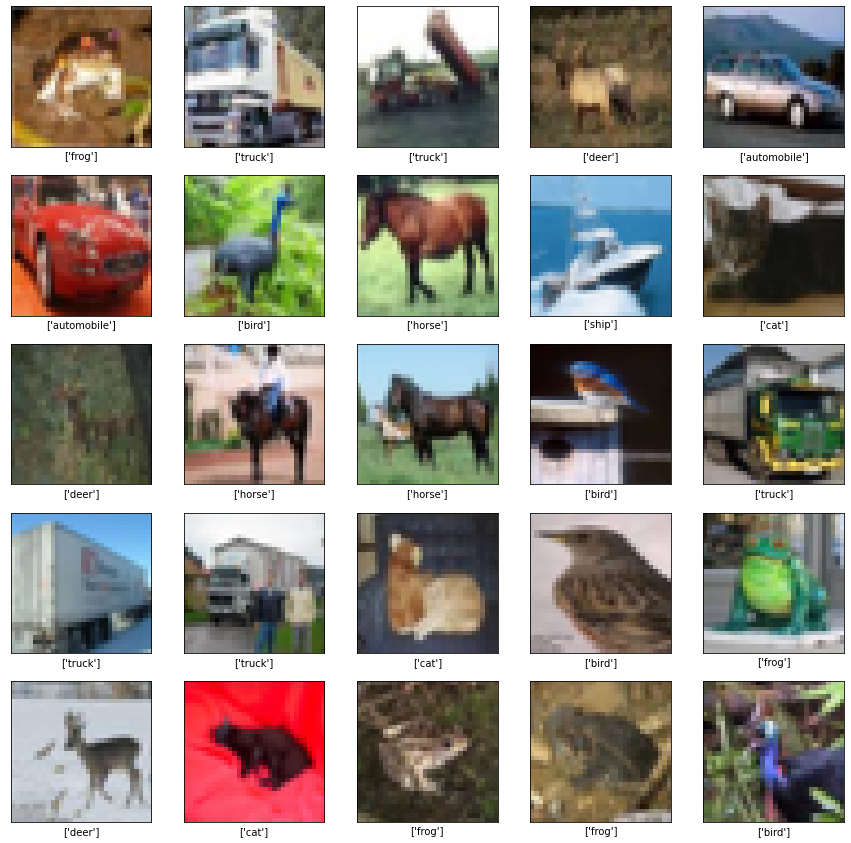

In [ ]:
print(x_train.shape)

plt.figure(figsize = (15, 15))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(labels[y_train[i]])

Basic Way

In [ ]:
def make_dic():
  with tf.variable_scope('Discriminator'):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides  = 2, activation = 'tanh', input_shape = [32, 32, 3]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides  = 2, activation = 'tanh'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer = tf.keras.initializers.random_uniform))
    model.add(tf.keras.layers.Dense(10, activation = 'softmax', kernel_initializer = tf.keras.initializers.random_uniform))

    return model

In [ ]:
discriminator = make_dic()

In [ ]:
def make_gen():
  with tf.variable_scope('Generator'):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(128, activation = 'relu', input_shape = [1, 100]))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(3072, activation = 'relu'))
    model.add(tf.keras.layers.Reshape([32, 32, 3]))

    return model

In [ ]:
generator = make_gen()

In [ ]:
noise_input = tf.placeholder(tf.float32, shape=[None, 1, 100])
real_image_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

gen_sample = generator(noise_input)

disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample)

stacked_gan = discriminator(gen_sample)

disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([128], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([128], dtype=tf.int32)))

disc_loss = disc_loss_real + disc_loss_fake

gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([128], dtype=tf.int32)))

optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5, beta2=0.999)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

train_gen = optimizer_gen.minimize(gen_loss, var_list = gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list = disc_vars)
"""
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
"""
init = tf.global_variables_initializer()

In [ ]:
sess = tf.Session()
sess.run(init)

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
dic_train_gen = data_gen.flow(x_train, y_train, batch_size = 128)
steps_per_epoch = x_train.shape[0] // 128

In [ ]:
def showImages():
    plt.figure(figsize = (12, 12))
    for i in range(9):
        z = np.random.uniform(-1., 1., size=[1, 1, 100])
        g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
        g = (g + 1.) / 2.
        g = -1 * (g - 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(g.reshape([32, 32, 3]))

In [ ]:
is_training = tf.placeholder(tf.bool)

batch = 128
epochs = 1000

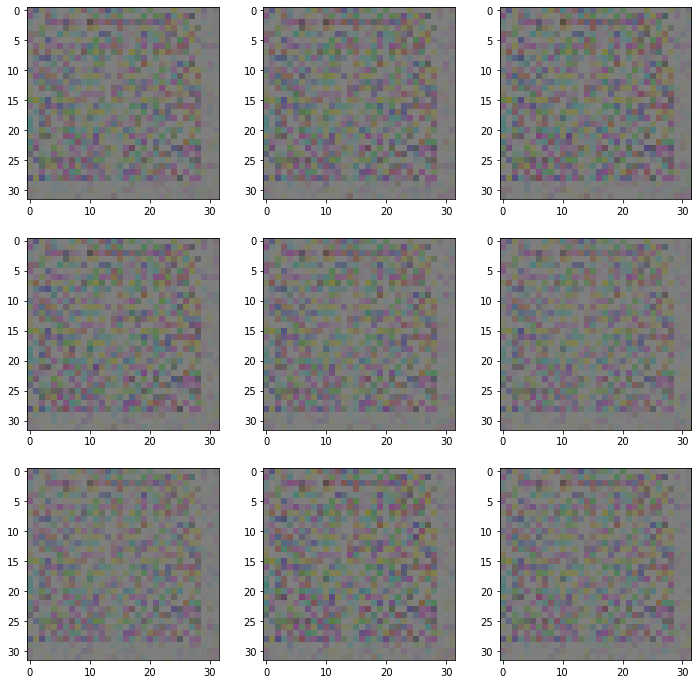

In [ ]:
for i in range(epochs):
    print('Eppch: ', i)
    idx = 0
    for j in range(int(x_train.shape[0] / 128.0)):
        batch_x = x_train[idx:(idx + 128)]
        idx = idx + 128
        #batch_x = np.reshape(batch_x, newshape=[-1, 32, 32, 3])

        # Rescale to [-1, 1], the input range of the discriminator
        batch_x = batch_x * 2. - 1.

        z = np.random.uniform(-1., 1., size=[batch, 1, 100])
        _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})

        z = np.random.uniform(-1., 1., size=[batch, 1, 100])
        _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})

        if i % 500 == 0 or i == 1:
            print('Step %i: Batch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, idx, gl, dl))
    if i % 100 == 0:
        showImages()

Stacked GAN way

In [ ]:
from tensorflow.keras import models, Sequential

In [ ]:
def make_dic(input_dim = (32, 32, 3)):
  model = Sequential()

  model.add(tf.keras.layers.Conv2D(64, (3, 3), strides = 2, input_shape = input_dim, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(128, (3, 3), strides = 2, input_shape = input_dim, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(256, (3, 3), strides = 2, input_shape = input_dim, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(512, (3, 3), strides = 2, input_shape = input_dim))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
  model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = opt, metrics = ['accuracy'])
  return model

In [ ]:
d_model = make_dic()
d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 512)         1

In [ ]:
def make_gen(latent_dim = 100):
  model = Sequential()

  model.add(tf.keras.layers.Dense(256*4*4, input_dim = latent_dim))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Reshape((4, 4, 256)))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(3, (3, 3), activation = 'tanh', padding = 'same'))
  
  return model

In [ ]:
g_model = make_gen()
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [ ]:
def create_stack(g_model, d_model):
  d_model.trainable = False

  model = Sequential()
  
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
  model.compile(optimizer = opt, loss = 'binary_crossentropy')

  return model

In [ ]:
GAN = create_stack(g_model, d_model)
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2077313   
Total params: 3,543,428
Trainable params: 1,466,115
Non-trainable params: 2,077,313
_________________________________________________________________


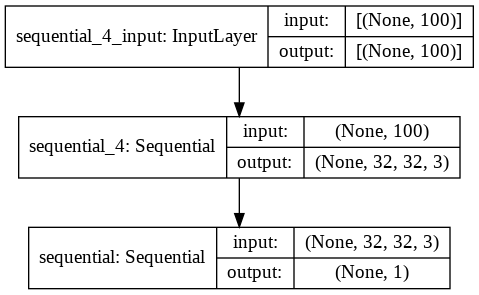

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(GAN, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

In [ ]:
def generate_real_sample(x_train, n_samples):
  idx = np.random.randint(0, x_train.shape[0], n_samples)
  x = x_train[idx]
  y = np.ones((n_samples, 1))

  return x, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)

  x = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))

  return x, y

In [ ]:
def periodic_evaluation(epoch, g_model, d_model, x_train, latent_dim, n_samples):
  x_real, y_real = generate_real_sample(x_train, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose = 0)

  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose = 0)

  print('Accuracy Real: %.0f%%, Fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
def save_fig(epoch):
  plt.figure(figsize = (12, 12))
  X = np.random.randn(100*25)
  X_input = X.reshape((25, 100))
  X = g_model.predict(X_input)

  X = (X + 1) / 2.0
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(X[i])

  filename = 'CIFR_' + str(epoch) + 'epoch.png'
  plt.savefig(filename)

In [ ]:
def train_gan(g_model, d_model, GAN, x_train, latent_dim = 100, epochs = 100, batch_size = 128):
  batch_per_epoch = int(x_train.shape[0] / batch_size)
  half_batch = int(batch_size / 2)
  real_loss = []
  fake_loss = []
  gan_loss = []

  d_loss1_avg, d_loss2_avg, g_loss_avg = 0, 0, 0
  
  for i in range(epochs):
    for j in range(batch_per_epoch):
      d_model.trainable = False
      x_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      g_loss = GAN.train_on_batch(x_gan, y_gan)
      gan_loss.append(g_loss)

    
      d_model.trainable = True
      x_real, y_real = generate_real_sample(x_train, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real, )

      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)

      real_loss.append(d_loss1)
      fake_loss.append(d_loss2)

    g_loss_avg = np.mean(gan_loss)
    d_loss1_avg = np.mean(real_loss)
    d_loss2_avg = np.mean(fake_loss)

    print('%d->, d_real = %.8f, d_fake = %.8f, g = %.8f' % (i + 1, d_loss1_avg, d_loss2_avg, g_loss_avg))
    
    real_loss = []
    fake_loss = []
    gan_loss = []
    
    if (i + 1) % 10 == 0:
      save_fig(i + 1)

    if (i + 1) % 25 == 0:
      path = '/Weights_DIC/Weights_' + str(i+1) + 'epoch'
      model.save_weights(path)

    periodic_evaluation(i, g_model, d_model, x_train, latent_dim, half_batch)

Streaming output truncated to the last 5000 lines.
63-> 73/390, d_real = 0.31624508, d_fake = 0.22145696, g = 2.55031300
63-> 74/390, d_real = 0.34583116, d_fake = 0.39338437, g = 2.22977281
63-> 75/390, d_real = 0.44718063, d_fake = 0.43060461, g = 2.41001487
63-> 76/390, d_real = 0.46610498, d_fake = 0.33615604, g = 2.44111037
63-> 77/390, d_real = 0.18232302, d_fake = 0.34427720, g = 2.19490480
63-> 78/390, d_real = 0.33062589, d_fake = 0.30597410, g = 2.31140518
63-> 79/390, d_real = 0.18498720, d_fake = 0.31271634, g = 2.13025188
63-> 80/390, d_real = 0.37110287, d_fake = 0.32977402, g = 2.43213367
63-> 81/390, d_real = 0.32597950, d_fake = 0.32615376, g = 2.33746266
63-> 82/390, d_real = 0.35450041, d_fake = 0.32862037, g = 2.39259243
63-> 83/390, d_real = 0.27165237, d_fake = 0.34338695, g = 2.23275661
63-> 84/390, d_real = 0.32038078, d_fake = 0.34031183, g = 2.40534878
63-> 85/390, d_real = 0.26999509, d_fake = 0.33910587, g = 2.35835910
63-> 86/390, d_real = 0.39998281, d_fak

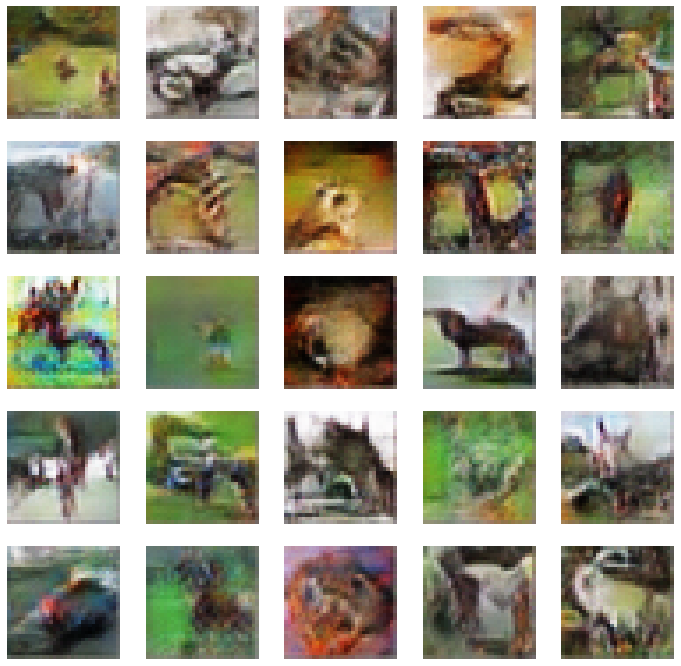

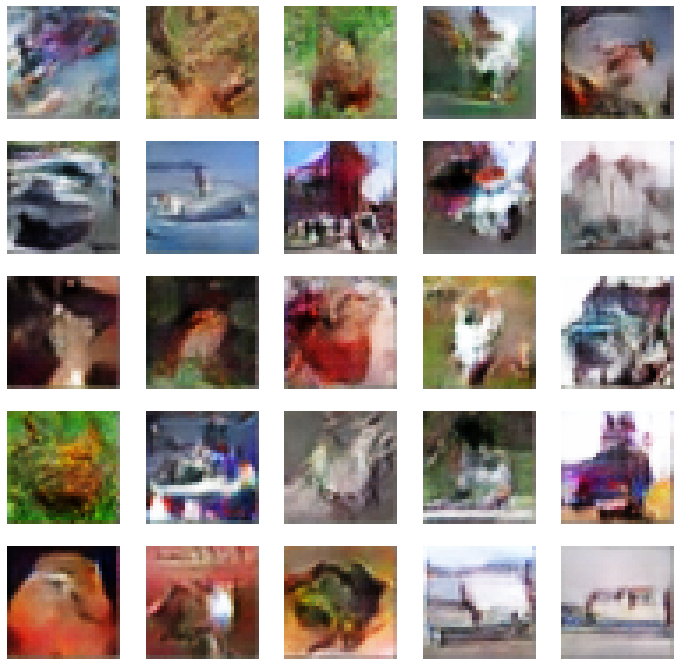

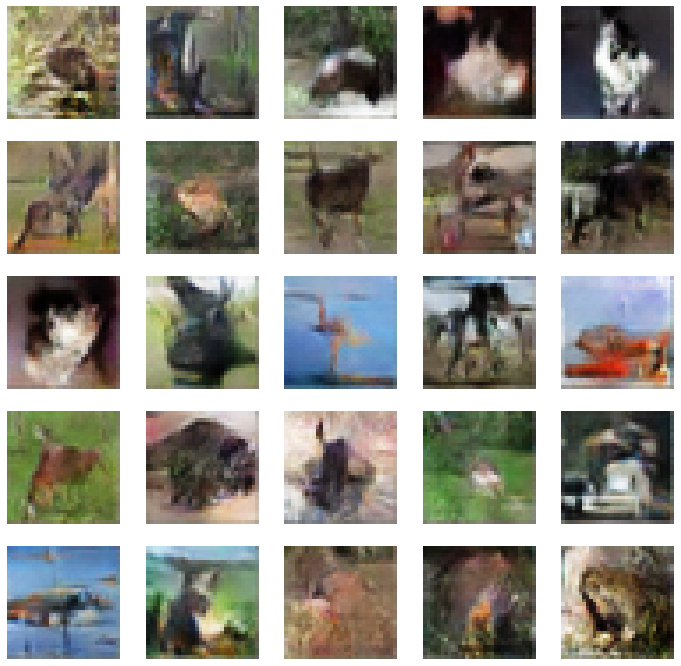

In [ ]:
train_gan(g_model, d_model, GAN, x_train, epochs = 75)

In [ ]:
d_model.save_weights('CIFR_dic_weights')

In [ ]:
g_model.save_weights('CIFR_gen_weights')